In [1]:
import os
from unittest import result 
from dotenv import load_dotenv

load_dotenv()
from langchain_groq import ChatGroq

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

llm= ChatGroq(model="llama-3.1-8b-instant")

result = llm.invoke("Hello")
result

AIMessage(content='How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 36, 'total_tokens': 44, 'completion_time': 0.010192143, 'prompt_time': 0.002586552, 'queue_time': 0.050920833, 'total_time': 0.012778695}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_ff2b098aaf', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--28cd8ad0-9bb6-4ef0-98b2-daa7f21a6a2f-0', usage_metadata={'input_tokens': 36, 'output_tokens': 8, 'total_tokens': 44})

In [2]:
from typing_extensions import Literal, TypedDict
from langgraph.graph import START, END, StateGraph
from IPython.display import Image, display
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage

## Schema for structured output to use as routing logic
class Route(BaseModel):
    step:Literal["poem", "story", "joke"] = Field(description="The nest step in the routing process")

## Augment the LLM with schema for structured output

router = llm.with_structured_output(Route)

## State
class State(TypedDict):
    input:str
    decision:str
    output:str


## Nodes
def llm_call1(state: State):
    """Write a story"""
    result = llm.invoke(state["input"])
    return {"output":result.content}


def llm_call2(state: State):
    """Write a joke"""
    print("llm_Call2 is called")
    result = llm.invoke(state["input"])
    return {"output":result.content}


def llm_call3(state: State):
    """Write a joke"""
    print("llm_Call3 is called")
    result = llm.invoke(state["input"])
    return {"output":result.content}


def llm_call_router(state:State):
    """Route the input to the appropriate node"""

    decision = router.invoke(
        [
            SystemMessage(
                content = "Route the input to story, joke or poem based on the users request"
            ),
            HumanMessage(
                content=state["input"]
            )
        ]
    )

    return {"decision":decision.step}

## Conditional edge function to route to the appropriate node
def route_decision(state:State):
    # return the node name you want to visit
    if state['decision'] == 'story':
        return "llm_call1"
    if state['decision'] == 'joke':
        return "llm_call3"
    if state['decision'] == 'poem':
        return "llm_call2"

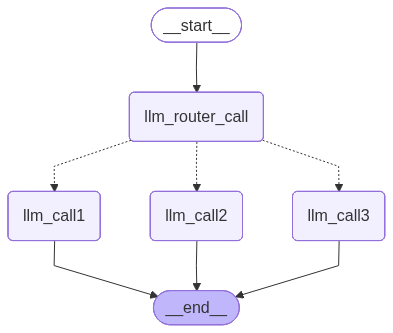

In [3]:
## Build the workflow
router_builder = StateGraph(State)

## Adding nodes
router_builder.add_node("llm_call1", llm_call1)
router_builder.add_node("llm_call2", llm_call2)
router_builder.add_node("llm_call3", llm_call3)
router_builder.add_node("llm_router_call", llm_call_router)

## Add edges to connect nodes
router_builder.add_edge(START, "llm_router_call")
router_builder.add_conditional_edges(
    "llm_router_call",
    route_decision,
    {
        "llm_call1":"llm_call1",
        "llm_call2":"llm_call2",
        "llm_call3":"llm_call3",
    }
)

## compile workflow
router_workflow = router_builder.compile()

## Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

In [5]:
state = router_workflow.invoke({"input":"Write me a joke about agentic ai"})
print(state["output"])

llm_Call3 is called
Why did the agentic AI go to therapy?

Because it was struggling to find its purpose and keep asking, "Am I driving the car, or is the car driving me?"
